# Spin Squeezing

See: J. Ma, X. Wang, C.P. Sun, and F. Nori Quantum spin squeezing. Phys. Rep. 509(2-3), 89-165 (2011). https://doi.org/10.1016/j.physrep.2011.08.003

Spin squeezing, similar to bosonic squeezing relies on the reduction in noise in one observable to increase measurement accuracy. Similar to bosonic squeezing, the uncertainty relation between two commuting observables is maintained, but with one observable "carrying" the noise of the other.

## One-axis twisting

Similar to the bosonic twisting case, we apply a non-linear hamiltonian to the initial state to create a one-axis twisting. In this example, we consider an ensemble of $N$ spin-$1/2$ particles described by collective operators $J_{\alpha} = \frac{1}{2}\sum\limits_{l=1}^{N}\sigma_{l\alpha}$, $\alpha = x,y,z$.

For a state starting in the negative-z axis $\lvert \downarrow \rangle$, we apply a one-axis twisting hamiltonian $$ H_{OAT} = \chi J_x^2 = \frac{\chi}{4} \sum\limits_{k,l = 1}^{N}\sigma_{kx}\sigma_{lx} $$
where $\chi$ is the coupling constant.

For the state at time $t$, the one-axis twisting angle is defined $\theta = 2\chi t$.

# Local Observables

We look at one local observable $\langle \sigma_{1z}\rangle$ to see some of the squeezing dynamics.

From the paper, we see that the expected value of this observable for a one-axis twisted state is 
$$ \langle \sigma_{1z} \rangle = -\cos^{N-1}(\theta / 2)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import math
import functools
import itertools

from qutip import *
from oqd_core.interface.analog.operator import *
from oqd_core.interface.analog.operation import *
from oqd_core.backend.metric import *
from oqd_core.backend.task import Task, TaskArgsAnalog
from oqd_analog_emulator.qutip_backend import QutipBackend

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def sum(args):
    return functools.reduce(operator.add, args)

def prod(args):
    return functools.reduce(operator.mul, args)

def tensor(args):
    return functools.reduce(operator.matmul, args)

In [6]:
N = 10
J = N / 2
chi = 0.01

def pauli(N, a, op):
    return tensor([op if i == a else PauliI() for i in range(N)])

def H_oat(N, chi):
    H = None
    for k in range(N):
        for l in range(N):
            if H is None:
                H = pauli(N, k, PauliX()) * pauli(N, l, PauliX())
            else:
                H = H + pauli(N, k, PauliX()) * pauli(N, l, PauliX())
    return (chi / 4) * H

def sigmapm(N, chi):
    s = None
    for k in range(N):
        for l in range(N):
            if s is None:
                s = pauli(N, k, PauliPlus()) * pauli(N, l, PauliMinus())
            else:
                s = s + pauli(N, k, PauliPlus()) * pauli(N, l, PauliMinus())
    return s

H = H_oat(N, chi)

circuit = AnalogCircuit()
circuit.evolve(duration=10, gate=AnalogGate(hamiltonian= H))

args = TaskArgsAnalog(
    n_shots=1000,
    fock_cutoff=1,
    metrics={
        "Jz": Expectation(operator=pauli(N, 1, PauliZ())),
    },
    dt=1e-3,
)

task = Task(program=circuit, args=args)

backend = QutipBackend()
results = backend.run(task=task)

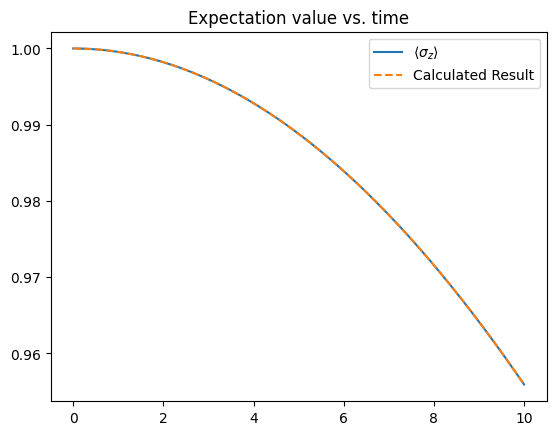

In [18]:
jz_res = np.array(results.metrics["Jz"])

theory_jz = np.cos(0.01 * np.array(results.times)) ** 9

plt.plot(results.times, jz_res, label=f"$\\langle \\sigma_z \\rangle$")
plt.plot(results.times, theory_jz, label="Calculated Result", linestyle="--")
plt.title("Expectation value vs. time")
plt.legend()